# INFO 6350 Final Project

For the final project, I look into a dataset I collected for one of my on-going projects. It was a dyad study inviting participants to work in pairs in social VR on a brainstorming task. Specifically, they were asked to come up with innovative ideas for water and energy conservation. There are three major types of data I collected throughout the study:
* Transcriptions of participants' conversations during the brainstorming processes.
* Participants' movement data collected through VR devices during the brainstorming processes.
* Post-task survey results inquiring participants' experiences during the brainstorming processes.

On top of the above data, we have multiple RAs in our lab going through those transcriptions and evaluating how creative each proposed idea in the brainstorming process was. Applying these data, I investigate two research questions in this final project:

**RQ1: Did participants' verbal and nonverbal behaviors synchronize during the brainstorming processes?**

With this research question, I am interested in whether participants' textual similarity correlate with their movement similarity during the study. That is, did participants get influenced by their partner and speak alike with each other throughout the study? Did participants who speak alike with their partner also move along with each other? And more importantly, can verbal or nonverbal synchrony predict how well participants perform in a brainstorming task? 

**RQ2: Can text analysis of participants' transcriptions predict their performance in the brainstorming task?**

The second research question is much more similar to what we have been working through the course -- that is, given some text data, can we predict their certain features? Here, I am interested in understanding each team's creativity as well as predicting the number of ideas they generated throughout the study through computational approaches to text analysis.

In the final project report, I show how the two research questions are addressed through text analysis. I first start with pulling in the raw transcription data.

# Pre-processing raw text data

In [1]:
from   collections import defaultdict
from   glob import glob
from   nltk import word_tokenize, sent_tokenize
import numpy as np
import os
import string
import pandas as pd

transcription_files = glob(os.path.join('individual_files', '*.csv'))

transcriptions = {} # Dictionary to hold results
for trans in transcription_files:
    f1 = pd.read_csv(trans)
    f1['text'] = f1['text'].astype(str)
    s1 = []
    for txt in f1['text']:
        s1.append(txt)
    s1 = ''.join(s1)
    trans_label = os.path.split(trans)[1].rstrip('.csv')
    transcriptions[trans_label] = s1

In [2]:
df_trans = pd.DataFrame.from_dict(transcriptions, orient='index')
df_trans.reset_index(level=0, inplace=True)
df_trans.columns = ['expID', 'text']
df_trans = df_trans.sort_values(by=['expID'])
df_trans

,expID,text
60,F002_459,"Yeah, it involves a lot of things. yes yeah, ..."
83,F002_494,So that was a very comprehensive list but yea...
51,F003_459,wow they like listed so much of what I was th...
115,F003_494,okay Yeah I know right that’s like 15 of the...
126,F004_459,You can have like rain barrels that collect r...
...,...,...
72,F091_494,"Okay, so um that was pretty extensive, but um..."
118,F092_459,"Hey Right, right. I think we can also use tra..."
28,F092_494,"Okay so if you do use water bottles, like pla..."
112,F099_459,"Oh, okay, so replacing your toilets with like..."


As shown in the table above, the current text data pulled from 154 transcriptions from 77 pairs participants (each individual participant was recorded on a separate transcription file). The next, I work on tagging each piece of text with the corresponding dyad ands subject ids.

In [3]:
# get dyad id
dl = []
for expid in df_trans['expID']:
    dyad = expid.split('_')[0]
    dl.append(dyad)
df_trans['dyad'] = dl

In [4]:
# get subject id
sl = []
for expid in df_trans['expID']:
    subj = expid.split('_')[1]
    if subj == '459':
        sl.append(1)
    else:
        sl.append(2)
df_trans['subject'] = sl

In [5]:
df_trans = df_trans.reset_index(drop=True)
df_trans

,expID,text,dyad,subject
0,F002_459,"Yeah, it involves a lot of things. yes yeah, ...",F002,1
1,F002_494,So that was a very comprehensive list but yea...,F002,2
2,F003_459,wow they like listed so much of what I was th...,F003,1
3,F003_494,okay Yeah I know right that’s like 15 of the...,F003,2
4,F004_459,You can have like rain barrels that collect r...,F004,1
...,...,...,...,...
149,F091_494,"Okay, so um that was pretty extensive, but um...",F091,2
150,F092_459,"Hey Right, right. I think we can also use tra...",F092,1
151,F092_494,"Okay so if you do use water bottles, like pla...",F092,2
152,F099_459,"Oh, okay, so replacing your toilets with like...",F099,1


<br/><br/><br/>
# RQ1: Verbal and Nonverbal Synchrony

**1. Get word similarity**

To address the first research question, I first generate several vectorizers, based on which I calculate the pairwise word similarity (i.e., cosine similrity examining word distances in pairwise transcriptions) of the two participants from each dyad. I didn't have specific pre-study hypotheses to pre-determine how I should set up my vectorizer. So, I instead take a more exploratory approach by getting the pairwise cosine similarities using all these different vectorizers and later on examine whether each of the results correlate with other nonverbal data I collected for the study. 

**1.1 Baseline count vectorizer**

I started with a "naive" count vectorizer as baseline. That is, I did minimal pre-processing and did not set much constrain on the vectorizer. Therefore, I didn't remove stop words, and I chose to include any word that occur as few as a single transcription as well as words that may occur in all conversations. I then standard-scaled the matrix, since I expect the output may be extremely sparse. However, I did not perform further feature selection afterwards either.

In [6]:
from   sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from   sklearn.metrics.pairwise import euclidean_distances, cosine_distances

count_vectorizer = CountVectorizer(
    encoding='utf-8',
    strip_accents='unicode', # or 'ascii' (faster but less robust)
    lowercase=True,
    stop_words=None, 
    min_df=1, # include words that occur in as few as a single document
    max_df=1.0, # include words that occur in as many as all documents
    binary=False # True = return 1 if word is present in document, else 0
)

# Perform vectorization
count_matrix = count_vectorizer.fit_transform(df_trans['text'])

# Print matrix shape
print("Matrix shape:", count_matrix.shape)

Matrix shape: (154, 3171)


In [8]:
# perform scaling
from sklearn.preprocessing import StandardScaler
count_matrix = StandardScaler().fit_transform(count_matrix.todense())

In [9]:
# calculate cosine distances
cos = cosine_distances(count_matrix)
cos

array([[0.        , 0.99213793, 0.98403134, ..., 0.99387167, 1.04013506,
        1.01300819],
       [0.99213793, 0.        , 1.0050936 , ..., 0.99584391, 1.00330825,
        1.01194708],
       [0.98403134, 1.0050936 , 0.        , ..., 1.01211103, 1.01272914,
        1.00344133],
       ...,
       [0.99387167, 0.99584391, 1.01211103, ..., 0.        , 1.031581  ,
        1.01104595],
       [1.04013506, 1.00330825, 1.01272914, ..., 1.031581  , 0.        ,
        0.96879812],
       [1.01300819, 1.01194708, 1.00344133, ..., 1.01104595, 0.96879812,
        0.        ]])

In [10]:
# get cosine distance for each dyad
cos_dist = []
for i, row in df_trans.iterrows():
    if row['subject'] == 1:
        cos_dist.append(cos[i][i+1])
    elif row['subject'] ==2:
        cos_dist.append(cos[i][i-1])

df_trans['count_similarity'] = cos_dist

**1.2 Improved count vectorizer**

On top of the baseline count vectorizer, I further revise it by removing stopwords and adjusting `min_df` and `max_df` when generating the vectorizer. One thing I consider problematic in the baseline vecotorizer was the fact that there are too many features in the matrix (i.e., with just 154 instances, the vectorizer yield 3,171 features!). Therefore, I spent some time to tweak with `min_df` and `max_df` following the process below:

In [105]:
from   sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from   sklearn.metrics.pairwise import euclidean_distances, cosine_distances

min_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
max_list = [10.0, 20.0, 30.0, 40.0, 50.0]

shape =[]
for mi in min_list:
    for ma in max_list:
        new_count_vectorizer = CountVectorizer(
            encoding='utf-8',
            strip_accents='unicode', # or 'ascii' (faster but less robust)
            lowercase=True,
            stop_words='english', 
            min_df=mi, 
            max_df=ma,
            binary=False)
        new_count_matrix = new_count_vectorizer.fit_transform(df_trans['text'])
        shape.append(new_count_matrix.shape)

In the end, I settle with min_df=8 and max_df=20.0 to create a vectorizer that does not yield too many features but also not potentially removing too much information from the text. 

In [11]:
new_count_vectorizer = CountVectorizer(
    encoding='utf-8',
    strip_accents='unicode', # or 'ascii' (faster but less robust)
    lowercase=True,
    stop_words='english', 
    min_df=8, 
    max_df=20.0,
    binary=False
)

# Perform vectorization
new_count_matrix = new_count_vectorizer.fit_transform(df_trans['text'])

# Print matrix shape
print("Matrix shape:", new_count_matrix.shape)

Matrix shape: (154, 333)


In [12]:
# perform scaling
new_count_matrix = StandardScaler().fit_transform(new_count_matrix.todense())

In [13]:
cos = cosine_distances(new_count_matrix)
cos.shape

(154, 154)

In [14]:
# get cosine distance for each dyad
cos_dist = []
for i, row in df_trans.iterrows():
    if row['subject'] == 1:
        cos_dist.append(cos[i][i+1])
    elif row['subject'] ==2:
        cos_dist.append(cos[i][i-1])

df_trans['new_count_similarity'] = cos_dist

**1.3 tfidf vectorizer**

Similarly, I went on to create different vectoerizers (tfidf, lemma, word tagging) and get pairwise cosine similarity between text for each pair of dyad. 

In [15]:
from   sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from   sklearn.metrics.pairwise import euclidean_distances, cosine_distances

# Set up the vectorizer object
tfidf_vectorizer = TfidfVectorizer(
    encoding='utf-8',
    strip_accents='unicode',
    lowercase=True,
    stop_words='english',
    min_df=8, # words appear in at least 5 dyads
    max_df=20.0, # words appear in up to 20 dyads
    binary=False,
    norm='l2',
    use_idf=True
)

# Perform vectorization
tfidf_matrix = tfidf_vectorizer.fit_transform(df_trans['text'])

# Print matrix shape
print("Matrix shape:", tfidf_matrix.shape)

Matrix shape: (154, 333)


In [16]:
# perform scaling
tfidf_matrix = StandardScaler().fit_transform(tfidf_matrix.todense())

In [17]:
cos = cosine_distances(tfidf_matrix)
cos.shape

(154, 154)

In [18]:
# get cosine distance for each dyad
cos_dist = []
for i, row in df_trans.iterrows():
    if row['subject'] == 1:
        cos_dist.append(cos[i][i+1])
    elif row['subject'] ==2:
        cos_dist.append(cos[i][i-1])

df_trans['tfidf_similarity'] = cos_dist

**1.4 lemma vectorizer**

In [19]:
# create a preprocessor: tokenize and lemmatize as indicated
def lemmatizer(text):
    import spacy
    import unicodedata
    nlp = spacy.load('en_core_web_sm')
    # remove punctuations
    text = text.translate(str.maketrans('', '', string.punctuation))
    # remove pure whitespaces
    text = " ".join(text.split())
    doc = nlp(text)
    lemmas = []
    for token in doc:
        lemmas.append(token.lemma_)
    return lemmas

In [20]:
# create vectorizer
lemma_vectorizer = TfidfVectorizer(
    input = 'content',
    encoding = 'utf-8',
    strip_accents = 'unicode',
    lowercase = True,
    tokenizer = lemmatizer,
    min_df = 8,
    max_features = None,
    use_idf=False
)

In [21]:
# Vectorize, scale, and score
# perform vectorization 
lemma_matrix = lemma_vectorizer.fit_transform(df_trans['text'])

# Check the dimensions of the matrix
print("Matrix shape:", lemma_matrix.shape)

Matrix shape: (154, 420)


In [22]:
# perform scaling
lemma_matrix = StandardScaler().fit_transform(lemma_matrix.todense())

In [23]:
cos = cosine_distances(lemma_matrix)
cos.shape

(154, 154)

In [24]:
# get cosine distance for each dyad
cos_dist = []
for i, row in df_trans.iterrows():
    if row['subject'] == 1:
        cos_dist.append(cos[i][i+1])
    elif row['subject'] ==2:
        cos_dist.append(cos[i][i-1])

df_trans['lemma_similarity'] = cos_dist

**1.5 Entities and POS tags vectorizer**

In [25]:
# Count entities and POS tags
valid_ent = ['PERSON', 'MONEY', 'TIME']
valid_pos = ['ADJ', 'ADV', 'AUX', 'CCONJ', 'DET', 'NOUN', 'PRON', 'PROPN', 'VERB']

import spacy
nlp = spacy.load('en_core_web_sm')

from collections import defaultdict

trans_data = []

for trans in df_trans['text']:
    counts = defaultdict(int)
    doc = nlp(trans)
    for ve in valid_ent:
        counts[ve] = 0
        for entity in doc.ents:
            if entity.label_ == ve:
                counts[ve] += 1
    for vp in valid_pos:
        counts[vp] = 0
        for token in doc:
            if token.pos_ == vp:
                counts[vp] += 1
    trans_data.append(counts)

In [26]:
trans_data[0:3]

[defaultdict(int,
             {'PERSON': 0,
              'MONEY': 0,
              'TIME': 0,
              'ADJ': 5,
              'ADV': 9,
              'AUX': 5,
              'CCONJ': 3,
              'DET': 10,
              'NOUN': 19,
              'PRON': 11,
              'PROPN': 2,
              'VERB': 19}),
 defaultdict(int,
             {'PERSON': 1,
              'MONEY': 0,
              'TIME': 0,
              'ADJ': 29,
              'ADV': 47,
              'AUX': 33,
              'CCONJ': 12,
              'DET': 39,
              'NOUN': 70,
              'PRON': 50,
              'PROPN': 6,
              'VERB': 70}),
 defaultdict(int,
             {'PERSON': 0,
              'MONEY': 0,
              'TIME': 0,
              'ADJ': 14,
              'ADV': 32,
              'AUX': 5,
              'CCONJ': 11,
              'DET': 29,
              'NOUN': 41,
              'PRON': 32,
              'PROPN': 5,
              'VERB': 53})]

In [27]:
# Vectorize counts, scale, and score

# perform vectorization
from sklearn.feature_extraction import DictVectorizer

tags_vectorizer = DictVectorizer(sparse=False)
tags_matrix = tags_vectorizer.fit_transform(trans_data)

# Check the dimensions of the matrix
print("Matrix shape:", tags_matrix.shape)

# perform scaling
tags_matrix = StandardScaler().fit_transform(tags_matrix)

Matrix shape: (154, 12)


In [28]:
cos = cosine_distances(tags_matrix)
cos.shape

(154, 154)

In [29]:
# get cosine distance for each dyad
cos_dist = []
for i, row in df_trans.iterrows():
    if row['subject'] == 1:
        cos_dist.append(cos[i][i+1])
    elif row['subject'] ==2:
        cos_dist.append(cos[i][i-1])

df_trans['tags_similarity'] = cos_dist

In [30]:
df_trans

,expID,text,dyad,subject,count_similarity,new_count_similarity,tfidf_similarity,lemma_similarity,tags_similarity
0,F002_459,"Yeah, it involves a lot of things. yes yeah, ...",F002,1,0.992138,0.983052,0.922402,0.857096,1.880515
1,F002_494,So that was a very comprehensive list but yea...,F002,2,0.992138,0.983052,0.922402,0.857096,1.880515
2,F003_459,wow they like listed so much of what I was th...,F003,1,0.956241,0.996876,0.985791,0.875957,0.509982
3,F003_494,okay Yeah I know right that’s like 15 of the...,F003,2,0.956241,0.996876,0.985791,0.875957,0.509982
4,F004_459,You can have like rain barrels that collect r...,F004,1,0.954561,0.886009,0.918848,0.932075,0.648655
...,...,...,...,...,...,...,...,...,...
149,F091_494,"Okay, so um that was pretty extensive, but um...",F091,2,1.005688,0.957168,0.940914,0.881237,1.476328
150,F092_459,"Hey Right, right. I think we can also use tra...",F092,1,0.987876,0.968790,0.946267,0.897468,1.881174
151,F092_494,"Okay so if you do use water bottles, like pla...",F092,2,0.987876,0.968790,0.946267,0.897468,1.881174
152,F099_459,"Oh, okay, so replacing your toilets with like...",F099,1,0.968798,0.927612,0.920624,0.808768,0.851115


<br/><br/>
**2. process movement data**

After getting all the word similarities using different types of vectorizers, I then work on processing nonverbal data, including participants' movement data, their post-study survey responses, and their creativity performance rated by multiple RAs.

For each participant, their head and hand positions were recorded once every second during the study. The table below shows an example of a single participant's movement data. (As required by IRB, I have to remove timestamp and display name from the data before showing this to anyone other than my PI and myself). As I am interested in the pairwise correlation of movement data (i.e., whether dyad participants move along with their partners), I then calculate the correlation and save it as `movement_corr`.

In [31]:
f1 = pd.read_csv('movement_data/movement_76_files/Start F002.csv').dropna(axis='columns')

# subset for Avatar X
m1 = f1[f1['displayName']=='Avatar X']
m1 = m1.drop(columns=['timestamp','displayName'])

# subset for Avatar Y
m2 = f1[f1['displayName']=='Avatar Y']
m2 = m2.drop(columns=['timestamp','displayName'])

In [32]:
m1

,head.position.x,head.position.y,head.position.z,hands.leftHand.position.x,hands.leftHand.position.y,hands.leftHand.position.z,hands.rightHand.position.x,hands.rightHand.position.y,hands.rightHand.position.z
0,0.861747,1.549898,-0.440936,-0.577186,0.700683,0.185317,-0.285085,0.732694,0.180704
2,0.861805,1.550011,-0.441064,-0.575090,0.700859,0.186833,-0.282622,0.732679,0.182533
4,0.861853,1.549972,-0.441384,-0.574554,0.700801,0.186446,-0.283574,0.733051,0.183090
6,0.861970,1.550174,-0.441739,-0.575299,0.700974,0.185641,-0.282888,0.733284,0.182048
8,0.862096,1.550204,-0.441968,-0.575101,0.700380,0.185667,-0.281741,0.732845,0.181902
...,...,...,...,...,...,...,...,...,...
17881,0.817317,1.533559,-0.415157,-0.599411,0.693169,0.227200,-0.230368,0.717488,0.253316
17883,0.816695,1.532990,-0.414543,-0.598705,0.693233,0.227284,-0.225954,0.719277,0.256166
17885,0.815973,1.533337,-0.413854,-0.600155,0.692585,0.228184,-0.220209,0.722898,0.257086
17887,0.815472,1.534267,-0.413372,-0.600908,0.693009,0.227669,-0.216674,0.728422,0.259692


In [33]:
from scipy.stats.stats import pearsonr
np.corrcoef(m1.mean().to_list(), m2.mean().to_list())[0][1]

0.4301561912903553

In [34]:
movement_files = glob(os.path.join('movement_data/movement_76_files', '*.csv'))

movements = {} # Dictionary to hold results
for move in movement_files:
    f1 = pd.read_csv(move).dropna(axis='columns')
    
    # subset for Avatar X
    m1 = f1[f1['displayName']=='Avatar X']
    m1 = m1.drop(columns=['timestamp','displayName'])

    # subset for Avatar Y
    m2 = f1[f1['displayName']=='Avatar Y']
    m2 = m2.drop(columns=['timestamp','displayName'])
    
    # movement correlation 
    move_corr = np.corrcoef(m1.mean().to_list(), m2.mean().to_list())[0][1]
    
    move_label = os.path.split(move)[1].rstrip('.csv')
    movements[move_label] = move_corr

In [35]:
df_move = pd.DataFrame.from_dict(movements, orient='index')
df_move = df_move.reset_index(level=0, inplace=False)
df_move = df_move.sort_values(by=['index'])
df_move = df_move.reset_index(level=0, inplace=False)
df_move = df_move.drop(columns=['level_0'])
df_move.columns = ['dyad', 'movement_corr']
df_move['dyad'] = df_move['dyad'].str.replace(r'Start ', '')
df_move

,dyad,movement_corr
0,F002,0.430156
1,F003,0.373476
2,F004,0.323330
3,F005,0.293375
4,F006,0.393278
...,...,...
70,F089,0.288916
71,F090,1.000000
72,F091,1.000000
73,F092,0.150074


<br/><br/>
**3. process survey data**

Several variables were measured in the post-task survey, including participants' perceived social closeness with their partners (`social_closeness`), avatar embodiment (i.e., to what extent they felt that the avatar represented their presence) (`avatar`), their sense of presence in VR (`presence`), the degree to which they cared about `choice_of_words`, `tone_of_voice`, and `nonverbal_cues` of their partners, and their evaluation for their partner's and their own performance during the brainstorming task (`self_eval` and `partner_eval`). For any multi-scale meausres, I work on getting their mean values before moving forward.

In [36]:
df_survey = pd.read_csv('survey_results_OSF.csv')
df_survey = df_survey[df_survey.columns.drop(list(df_survey.filter(regex='Date')))]
df_survey = df_survey[df_survey.columns.drop(list(df_survey.filter(regex='file')))]
df_survey = df_survey.sort_values(by=['expID'])
df_survey.head()

,expID,Condition,Appearance,Room,social_closeness_01,social_closeness_02,social_closeness_03,social_closeness_04,social_closeness_05,social_closeness_06,...,avatar_02,avatar_03,avatar_04,avatar_05,presence_01,presence_02,presence_03,presence_04,motion_sickness,first_vr
0,F002,Collaboration,Avatar,2,1,4,3,4,4,4,...,2,3,2.0,2,3,3,4,2,1,1
1,F002,Collaboration,Avatar,1,1,3,3,4,3,4,...,2,2,3.0,2,3,2,4,3,1,0
2,F003,Competition,Cube,2,1,5,2,3,4,2,...,5,5,5.0,5,5,3,5,5,1,1
3,F003,Competition,Cube,1,1,4,4,4,5,4,...,3,2,3.0,1,3,2,4,3,1,1
4,F004,Competition,Cube,1,1,3,3,2,4,5,...,2,1,3.0,2,1,1,3,1,1,0


In [37]:
# get average of social closeness measurement scales
sc_cols = [col for col in df_survey.columns if 'social_closeness' in col]
df_survey['social_closeness'] = df_survey[sc_cols].mean(axis=1)

# get average of avatar embodiment measurement scales
ae_cols = [col for col in df_survey.columns if 'avatar' in col]
df_survey['avatar_embodiment'] = df_survey[ae_cols].mean(axis=1)

# get average of presence measurement scales
ps_cols = [col for col in df_survey.columns if 'presence' in col]
df_survey['presence'] = df_survey[ps_cols].mean(axis=1)

# get average of partner evaluation scales
pe_cols = [col for col in df_survey.columns if 'partner' in col]
df_survey['partner_eval'] = df_survey[pe_cols].mean(axis=1)

# get average of partner evaluation scales
se_cols = [col for col in df_survey.columns if 'self_evaluation' in col]
df_survey['self_eval'] = df_survey[se_cols].mean(axis=1)


# drop original scales
df_survey = df_survey[df_survey.columns.drop(list(df_survey.filter(regex='social_closeness_')))]
df_survey = df_survey[df_survey.columns.drop(list(df_survey.filter(regex='avatar_0')))]
df_survey = df_survey[df_survey.columns.drop(list(df_survey.filter(regex='presence_0')))]
df_survey = df_survey[df_survey.columns.drop(list(df_survey.filter(regex='partner_evaluation')))]
df_survey = df_survey[df_survey.columns.drop(list(df_survey.filter(regex='self_evaluation')))]


df_survey

,expID,Condition,Appearance,Room,choice_of_words,tone_of_voice,nonverbal_cues,motion_sickness,first_vr,social_closeness,avatar_embodiment,presence,partner_eval,self_eval
0,F002,Collaboration,Avatar,2,0,0,0,1,1,3.545455,2.4,3.00,2.0,3.0
1,F002,Collaboration,Avatar,1,0,0,0,1,0,2.545455,2.4,3.00,2.0,2.0
2,F003,Competition,Cube,2,3,2,1,1,1,3.090909,4.6,4.50,4.0,4.0
3,F003,Competition,Cube,1,2,3,1,1,1,4.000000,2.0,3.00,2.0,2.0
4,F004,Competition,Cube,1,1,3,2,1,0,3.272727,1.8,1.50,2.5,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,F091,Collaboration,Cube,1,2,3,1,1,0,4.000000,1.4,2.25,1.0,2.0
148,F092,Collaboration,Cube,1,2,3,1,1,0,1.909091,1.0,2.50,2.5,1.0
149,F092,Collaboration,Cube,2,2,3,1,1,1,3.545455,1.8,2.00,2.0,2.0
150,F099,Competition,Cube,2,2,3,1,2,0,3.454545,2.2,3.75,2.0,2.0


In [38]:
# subset dataframe by subject id
df_r1 = df_survey[df_survey['Room']==1]
df_r2 = df_survey[df_survey['Room']==2]

df_survey_comb = pd.DataFrame()
df_survey_comb['dyad'] = df_r1['expID'].to_list()
df_survey_comb['condition'] = df_r1['Condition'].to_list()
df_survey_comb['appearance'] = df_r1['Appearance'].to_list()

# get the differences in survey responses in each dyad
cols = ['choice_of_words', 'tone_of_voice', 'nonverbal_cues', 'social_closeness', 
        'avatar_embodiment', 'presence', 'partner_eval', 'self_eval']
for col in cols:
    diff_list = []
    i = 0
    for i in range(len(df_survey_comb)):
        diff_list.append(abs(df_r1.iloc[i][col]-df_r2.iloc[i][col]))
        i += 1
    df_survey_comb[col] = diff_list

In [39]:
df_survey_comb

,dyad,condition,appearance,choice_of_words,tone_of_voice,nonverbal_cues,social_closeness,avatar_embodiment,presence,partner_eval,self_eval
0,F002,Collaboration,Avatar,0,0,0,1.000000,0.0,0.00,0.0,1.0
1,F003,Competition,Cube,1,1,0,0.909091,2.6,1.50,2.0,2.0
2,F004,Competition,Cube,1,0,1,0.272727,0.6,2.50,0.5,1.0
3,F005,Competition,Avatar,2,3,1,0.727273,0.0,1.00,0.0,1.0
4,F006,Collaboration,Avatar,0,0,0,0.727273,1.6,2.00,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
71,F089,Competition,Avatar,2,3,1,1.545455,2.2,1.50,1.0,1.0
72,F090,Competition,Cube,1,1,2,0.090909,2.0,0.50,1.0,1.0
73,F091,Collaboration,Cube,0,0,0,0.454545,1.2,2.50,0.5,0.0
74,F092,Collaboration,Cube,0,0,0,1.636364,0.8,0.50,0.5,1.0


<br/><br/>
**4. process creativity measures**

Multiple RAs read and analyzed the transcriptions on a sentense-by-sentense level to evaluate participants' performance during the brainstorming task. For each idea generated, the RAs rated its degree of creativity by looking at the level of information embedded in the idea (`info`), the degree to which a participant demonstrated divergent thinking (`divergence`), the logical connection of an idea to their partners' or their own previous ideas (`logic_partner` and `logic_self`), as well as how rare an idea seemed to occur within the group of sample (`rare_score`). 

In the end, I look at the total scores of "creativity" and the number of ideas being generated as outcome variables of the brainstorming task.

In [40]:
# read csv of creativity scores for each idea generated
df_creativity = pd.read_csv('creativity_linko.csv')
# get columns needed for the present analysis
df_creativity = df_creativity[['dyad','info','divergence','logic_self','logic_partner',
                               'rare_score','link_rare_score','creativity']]
df_creativity = df_creativity.sort_values(by=['dyad'])
print(df_creativity.shape)
df_creativity.head()

(3065, 8)


,dyad,info,divergence,logic_self,logic_partner,rare_score,link_rare_score,creativity
1328,F002,0,0,0,0,0.595728,0.985507,0.000000
1311,F002,1,1,0,0,0.993135,0.994661,3.987796
1335,F002,1,1,0,1,0.993898,0.998474,3.992372
1334,F002,1,1,0,0,0.993898,0.993898,3.987796
1333,F002,2,2,0,0,0.999237,0.996949,5.996186


In [41]:
# get mean scores of creativity measures for each dyad
df_creativity = df_creativity.groupby(by=["dyad"]).mean().reset_index()
print(df_creativity.shape)

(78, 8)


In [42]:
# get total number of ideas generated by each dyad
df_idea_count = pd.read_csv('creativity_count.csv')
df_idea_count['total_idea'] = df_idea_count['Total Idea for RM2'] + df_idea_count['Total Idea for RM1']
df_idea_count = df_idea_count[['Experiment ID','total_idea']]
df_idea_count.columns = ['dyad','total_idea']
df_idea_count

,dyad,total_idea
0,F002,20
1,F003,23
2,F004,23
3,F005,21
4,F006,11
...,...,...
151,F089,23
152,F090,21
153,F091,18
154,F092,29


Note that we have multiple RAs coding participants' brainstormed ideas. Therefore, I was trying to get the mean value for each dyad.

In [43]:
# get mean count of ideas for each dyad
df_idea_count = df_idea_count.groupby(by=["dyad"]).mean().reset_index()

# merge the idea count results with creativity measures
df_creativity = pd.merge(df_creativity, df_idea_count, on='dyad',how='left').dropna()

# get only the final creativity scores and the count of total ideas to avoid collinearity
df_creativity = df_creativity[['dyad','creativity','total_idea']]
df_creativity

,dyad,creativity,total_idea
0,F002,3.985934,21.0
1,F003,1.965141,24.0
2,F004,3.173487,23.0
3,F005,4.390011,21.0
4,F006,3.941436,12.5
...,...,...,...
73,F089,2.193971,19.5
74,F090,2.790195,21.5
75,F091,2.100686,16.0
76,F092,4.242008,29.0


<br/><br/>
**5. combine all dataframes**

Finally, I combined all the above datasets and create a large correlation matrix to examine whether participants' verbal and nonverbal behaviors during brainstorming synchronized with one another.

In [45]:
# subset dataframe by subject id
df_s1 = df_trans[df_trans['subject']==1]
df_s2 = df_trans[df_trans['subject']==2]

df_trans_comb = pd.DataFrame()
df_trans_comb['dyad'] = df_s1['dyad']
df_trans_comb['text_1'] = df_s1['text'].to_list()
df_trans_comb['text_2'] = df_s2['text'].to_list()

# get word similarity for each dyad
df_trans_comb['count_similarity'] = df_s1['count_similarity']
df_trans_comb['new_count_similarity'] = df_s1['new_count_similarity']
df_trans_comb['tfidf_similarity'] = df_s1['tfidf_similarity']
df_trans_comb['lemma_similarity'] = df_s1['lemma_similarity']
df_trans_comb['tags_similarity'] = df_s1['tags_similarity']
df_trans_comb = df_trans_comb.reset_index(drop=True)

# get movement correlation for each dyad
df_trans_comb = pd.merge(df_trans_comb, df_move, on='dyad',how='left').dropna()

# get survey results for each dyad
df_trans_comb = pd.merge(df_trans_comb, df_survey_comb, on='dyad',how='left').dropna()

# get creativity measures for each dyad
df_trans_comb = pd.merge(df_trans_comb, df_creativity, on='dyad',how='left').dropna()


df_trans_comb

,dyad,text_1,text_2,count_similarity,new_count_similarity,tfidf_similarity,lemma_similarity,tags_similarity,movement_corr,condition,...,choice_of_words,tone_of_voice,nonverbal_cues,social_closeness,avatar_embodiment,presence,partner_eval,self_eval,creativity,total_idea
0,F002,"Yeah, it involves a lot of things. yes yeah, ...",So that was a very comprehensive list but yea...,0.992138,0.983052,0.922402,0.857096,1.880515,0.430156,Collaboration,...,0,0,0,1.000000,0.0,0.00,0.0,1.0,3.985934,21.0
1,F003,wow they like listed so much of what I was th...,okay Yeah I know right that’s like 15 of the...,0.956241,0.996876,0.985791,0.875957,0.509982,0.373476,Competition,...,1,1,0,0.909091,2.6,1.50,2.0,2.0,1.965141,24.0
2,F004,You can have like rain barrels that collect r...,Okay you can when you're brushing your teet...,0.954561,0.886009,0.918848,0.932075,0.648655,0.323330,Competition,...,1,0,1,0.272727,0.6,2.50,0.5,1.0,3.173487,23.0
3,F005,"Okay,hello. Wait. Okay, first I just wanted to...",Yeah. How about using a fan Or like opening a ...,0.965429,0.833697,0.840660,0.938767,0.943674,0.293375,Competition,...,2,3,1,0.727273,0.0,1.00,0.0,1.0,4.390011,21.0
4,F006,"Oh, yeah. Okay. Right. Right. Right.Um, where ...","Okay, well, that that covered a lot of bases. ...",1.016902,0.908587,0.888811,0.948064,1.645360,0.393278,Collaboration,...,0,0,0,0.727273,1.6,2.00,1.0,0.0,3.941436,12.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,F089,"okay, how about recapturing water from storms...",that could work. I was also thinking about ho...,0.970180,0.992258,0.994599,0.986522,0.885655,0.288916,Competition,...,2,3,1,1.545455,2.2,1.50,1.0,1.0,2.193971,19.5
71,F090,if you take shorter showers uhm before openin...,"yep, another one would be – keeping it in the...",0.990186,0.955493,0.879956,0.843587,1.768696,1.000000,Competition,...,1,1,2,0.090909,2.0,0.50,1.0,1.0,2.790195,21.5
72,F091,"I agree, that would increase like their trust...","Okay, so um that was pretty extensive, but um...",1.005688,0.957168,0.940914,0.881237,1.476328,1.000000,Collaboration,...,0,0,0,0.454545,1.2,2.50,0.5,0.0,2.100686,16.0
73,F092,"Hey Right, right. I think we can also use tra...","Okay so if you do use water bottles, like pla...",0.987876,0.968790,0.946267,0.897468,1.881174,0.150074,Collaboration,...,0,0,0,1.636364,0.8,0.50,0.5,1.0,4.242008,29.0


In [46]:
# create correlation matrix
df_trans_comb.corr()

,count_similarity,new_count_similarity,tfidf_similarity,lemma_similarity,tags_similarity,movement_corr,choice_of_words,tone_of_voice,nonverbal_cues,social_closeness,avatar_embodiment,presence,partner_eval,self_eval,creativity,total_idea
count_similarity,1.000000,0.463335,0.371912,0.527272,0.226244,-0.107990,-0.009174,0.030361,0.005550,0.002674,0.168626,0.019496,0.194416,0.035567,0.183635,0.085243
new_count_similarity,0.463335,1.000000,0.917249,0.587139,0.126028,0.059638,0.055974,-0.040041,0.048795,-0.010733,0.106773,-0.120367,0.183287,0.264939,0.068142,0.205327
tfidf_similarity,0.371912,0.917249,1.000000,0.622851,-0.099432,0.108978,0.051067,-0.054626,0.001302,0.060976,-0.020463,-0.111944,0.217371,0.203479,0.105801,0.129512
lemma_similarity,0.527272,0.587139,0.622851,1.000000,0.021267,0.036559,-0.023054,-0.045908,-0.039917,0.211396,0.181732,-0.040923,0.404694,0.183620,-0.013696,0.015247
tags_similarity,0.226244,0.126028,-0.099432,0.021267,1.000000,-0.159784,-0.117426,0.033864,-0.042846,0.023948,0.270161,0.151949,-0.088699,0.110223,0.161955,0.057356
movement_corr,-0.107990,0.059638,0.108978,0.036559,-0.159784,1.000000,-0.127296,-0.013475,-0.022934,0.085996,-0.011717,0.109816,-0.022095,-0.036393,-0.061218,0.000184
choice_of_words,-0.009174,0.055974,0.051067,-0.023054,-0.117426,-0.127296,1.000000,0.807654,0.732760,-0.039481,-0.196914,-0.029968,0.125031,0.190562,0.074995,0.090225
tone_of_voice,0.030361,-0.040041,-0.054626,-0.045908,0.033864,-0.013475,0.807654,1.000000,0.549260,0.029860,-0.090603,0.011251,0.040323,0.213950,0.081264,0.063736
nonverbal_cues,0.005550,0.048795,0.001302,-0.039917,-0.042846,-0.022934,0.732760,0.549260,1.000000,-0.080909,-0.027012,0.073967,0.053130,0.135758,0.042185,0.137854
social_closeness,0.002674,-0.010733,0.060976,0.211396,0.023948,0.085996,-0.039481,0.029860,-0.080909,1.000000,0.244349,0.090032,0.409136,0.151661,0.027545,-0.189219


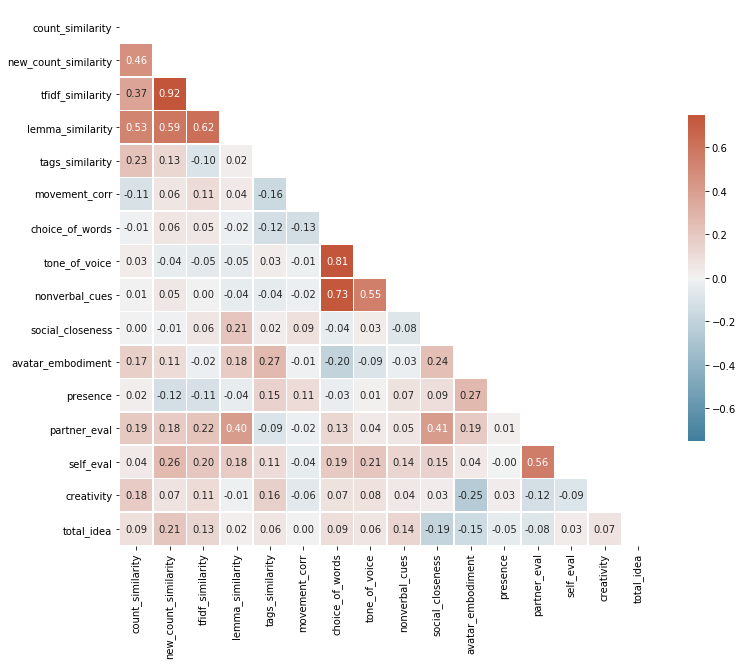

In [48]:
# create visualization for the correlation matrix
from string import ascii_letters
import seaborn as sns
import matplotlib.pyplot as plt

corrMatrix = df_trans_comb.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corrMatrix, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corrMatrix, mask=mask, cmap=cmap, vmax=0.75, center=0, vmin=-0.75, square=True, 
            linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".2f")

The correlation matrix shows that participants' verbal and nonverbal behaviors during the brainstorming task didn't correlate much during the brainstorming task, nor did the degree synchrony suggest each team's performance in the study. Overall, correlation coefficients are low in the matrix above. We can only see that word similarities calculated by different types of vectorizers relate to one another, while participants who cared about choices of words also tended to care more about tone of voices and other nonverbal cues (as the three variables are highly correlated).

Moving forward, I chose to use word similarities calculated by the tfidf vectorizer, as it seems to show stronger correlation with both creativity and total ideas generated, as compared to word similarities generated by other vectorizers, though all of these coefficients remain low.

<br/><br/>
# RQ2: Predicting brainstorming performance through text analysis

While we can learn from RQ1 that synchrony between partners didn't seem strong and nor did it predict participants' performance, I then move on to investigate RQ2. Prior to taking a closer look at the text, a natural questions to ask was whether text data does provide more information than the other nonverbal measurements. To answer this question, I first perform some exploratory evaluation using linear regression and clustering.

# Evaluating Linear Regression

Here, I compare linear regression models fit by the above synchrony/nonverbal measures vs. text data to predict both the scores of creativity as well as the number of ideas being generated. 

(Please note that my goal here is not to create a perfect predictive model yet, but just to evaluate whether text provides more information than other nonverbal measures to predict participants' performance)

**1. predicting creativity**

**1.1. fit model with synchrony/nonverbal measures**

In [138]:
# Fit and predict using LinearRegression()
from sklearn.linear_model import LinearRegression

X = df_trans_comb[['tfidf_similarity','movement_corr','choice_of_words', 'tone_of_voice','nonverbal_cues', 
                   'social_closeness', 'avatar_embodiment', 'presence','partner_eval', 'self_eval']]
y_creativity = df_trans_comb['creativity'].to_list()
y_idea = df_trans_comb['total_idea'].to_list()

In [141]:
# Fit and predict creativity scores
reg = LinearRegression().fit(X, y_creativity)
y_pred = reg.predict(X)

In [142]:
from sklearn.model_selection import cross_val_score
print(cross_val_score(reg, X, y_creativity, cv=10, scoring='r2'))

[ 0.12394489 -0.15985272 -0.9235435  -0.1729911  -0.4362116  -0.47113391
 -6.96313331 -0.07653197 -0.21957413 -0.07648829]


In [143]:
# print some regression outputs
print('Scores:', reg.score(X, y_creativity))

df_coef = pd.DataFrame()
df_coef['predictor'] = ['tfidf_similarity', 'movement_corr','choice_of_words', 'tone_of_voice','nonverbal_cues', 
                        'social_closeness', 'avatar_embodiment', 'presence','partner_eval', 'self_eval']
df_coef['coefficient'] = reg.coef_
df_coef

Scores: 0.13565347586404441


,predictor,coefficient
0,tfidf_similarity,1.858041
1,movement_corr,-0.425243
2,choice_of_words,-0.158673
3,tone_of_voice,0.129667
4,nonverbal_cues,0.126699
5,social_closeness,0.268693
6,avatar_embodiment,-0.345118
7,presence,0.123713
8,partner_eval,-0.124561
9,self_eval,-0.105675


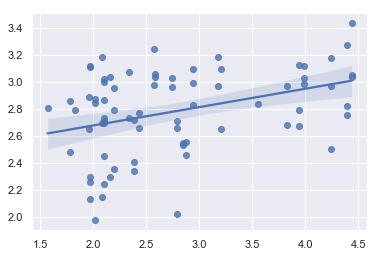

In [144]:
# Plot y_pred vs. y
import seaborn as sns; sns.set_theme(color_codes=True)
ax = sns.regplot(x=y_creativity, y=y_pred)

**1.2. fit model with text vectorizer**

In [150]:
# Fit and predict creativity scores
reg = LinearRegression().fit(X_standard, y_creativity)
y_pred = reg.predict(X_standard)

In [151]:
# R^2, overfitted, using .score() on all data
print("Matrix score:", round(reg.score(X_standard, y_creativity), 6))

Matrix score: 1.0


In [152]:
from sklearn.model_selection import cross_val_score
cross_val_score(reg, X_standard, y_creativity, cv=10, scoring='r2').mean()

-0.21696660944836266

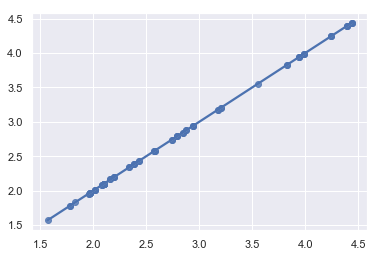

In [158]:
# Plot y_pred vs. y
import seaborn as sns; sns.set_theme(color_codes=True)
ax = sns.regplot(x=y_creativity, y=y_pred.tolist())

By looking at the regression scores, 10-fold cross-validation scores, and regression plots, the model fit by word vectorizer clearly shows the potential to accurately predict the degree of creativity among our sample (even though the current model is overfitted).

**2. predicting the count of ideas**

**2.1. fit model with synchrony/nonverbal measures**

In [53]:
# Fit and predict creativity scores
reg = LinearRegression().fit(X, y_idea)
y_pred = reg.predict(X)

In [54]:
# print some regression outputs
print('Scores:', reg.score(X, y_idea))

df_coef = pd.DataFrame()
df_coef['predictor'] = ['tfidf_similarity', 'movement_corr','choice_of_words', 'tone_of_voice','nonverbal_cues', 
                        'social_closeness', 'avatar_embodiment', 'presence','partner_eval', 'self_eval']
df_coef['coefficient'] = reg.coef_
df_coef

Scores: 0.0875098044644197


,predictor,coefficient
0,tfidf_similarity,13.155888
1,movement_corr,-0.486480
2,choice_of_words,-1.135660
3,tone_of_voice,0.470410
4,nonverbal_cues,2.386368
5,social_closeness,-2.311428
6,avatar_embodiment,-1.107734
7,presence,-0.002104
8,partner_eval,-0.524381
9,self_eval,0.383905


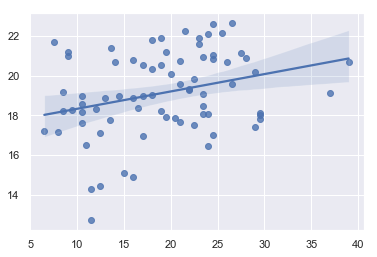

In [55]:
# Plot y_pred vs. y
import seaborn as sns; sns.set_theme(color_codes=True)
ax = sns.regplot(x=y_idea, y=y_pred)

**2.2. fit model with text vectorizer**

In [159]:
# Fit and predict creativity scores
reg = LinearRegression().fit(X_standard, y_idea)
y_pred = reg.predict(X_standard)

In [160]:
# R^2, overfitted, using .score() on all data
print("Matrix score:", round(reg.score(X_standard, y_idea), 6))

Matrix score: 1.0


In [161]:
from sklearn.model_selection import cross_val_score
cross_val_score(reg, X_standard, y_idea, cv=10, scoring='r2').mean()

0.06885571384792617

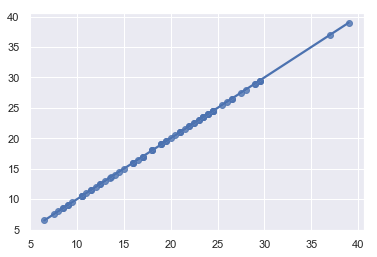

In [162]:
# Plot y_pred vs. y
import seaborn as sns; sns.set_theme(color_codes=True)
ax = sns.regplot(x=y_idea, y=y_pred.tolist())

We again see similar trends when predicting the number of ideas being generated. That is, fitting models with word vectorizer seems to create prediction models that can more accurately tell how many ideas a participant may generate. Additionally, we can see that the performance of both models was worse than that of the two models designed to predict the level of creativity. This suggests perhaps text data can provide more information that is more contextual, rather than merely quantitative.

<br/><br/><br/>
# Clustering

The next, I experimented with some unsupervised approaches to see whether the text transcriptions themselves are different enough to demonstrate different clusters in feature spaces. That is, if the text per se do not really show different patterns, then perhaps it won't offer much insight. 

In [56]:
from   sklearn.cluster import KMeans, SpectralClustering, DBSCAN, OPTICS, AgglomerativeClustering

# Plotting function
def plot_compare(X, labels, title, reduce=True, alpha=0.2):
    '''
    Takes an array of object data, a set of cluster labels, and a title string
    Reduces dimensions to 2 and plots the clustering.
    Returns nothing.
    '''
    import matplotlib.pyplot as plt
    import seaborn as sns
    from   sklearn.decomposition import TruncatedSVD

    if reduce:
        # TruncatedSVD is fast and can handle sparse inputs
        # PCA requires dense inputs; MDS is slow
        coordinates = TruncatedSVD(n_components=2).fit_transform(X)
    else:
        # Optionally handle 2-D inputs
        coordinates = X
    
    # Set up figure
    fig, ax = plt.subplots(figsize=(12,6))

    # Unlabeled data
    plt.subplot(121) # 1x2 plot, position 1
    plt.scatter(
        coordinates[:, 0], 
        coordinates[:, 1], 
        alpha=alpha, # Set transparency so that we can see overlapping points
        linewidths=0 # Get rid of marker outlines
    )
    plt.title("Unclustered data")

    # Labeled data
    plt.subplot(122)
    sns.scatterplot(
        x=coordinates[:, 0], 
        y=coordinates[:, 1],
        hue=labels,
        alpha=alpha,
        palette='viridis',
        linewidth=0
    )
    plt.title(title)
    plt.show()

CPU times: user 311 ms, sys: 1.96 ms, total: 313 ms
Wall time: 318 ms
kMeans label vector shape: (75,)


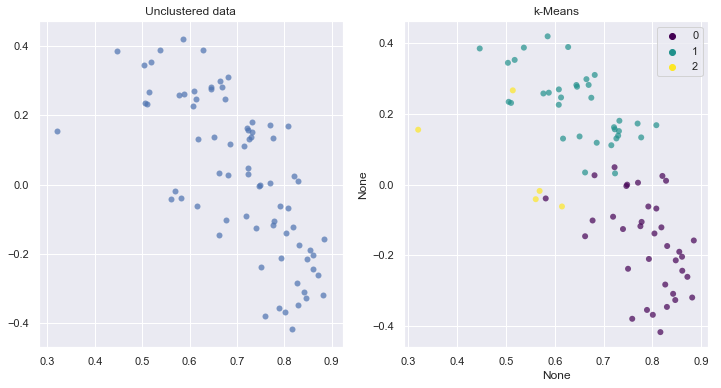

In [57]:
df_trans_comb['text_comb'] = df_trans_comb['text_1'] + df_trans_comb['text_2']

# Perform k-Means clustering with n_clusters = 3
X_tfidf = tfidf_vectorizer.fit_transform(df_trans_comb['text_comb'])

# Set up clsutering object
kmeans = KMeans(n_clusters=3)

# Perform clustering and return labels
%time y_kmeans = kmeans.fit_predict(X_tfidf)

# Print label vector shape
print("kMeans label vector shape:", y_kmeans.shape)

# Plot results
plot_compare(X_tfidf, y_kmeans, 'k-Means', alpha=0.7)

CPU times: user 254 ms, sys: 3.09 ms, total: 257 ms
Wall time: 257 ms
kMeans label vector shape: (75,)


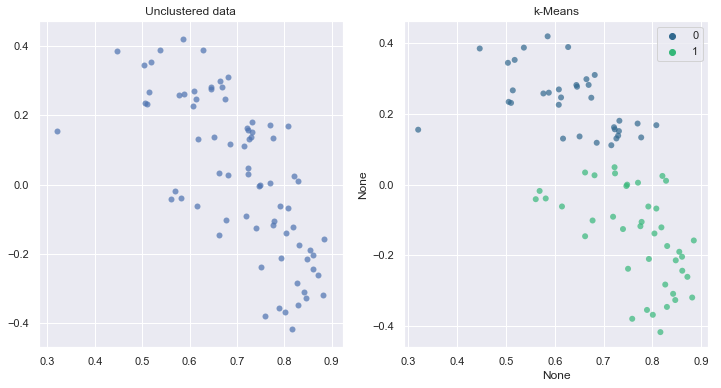

In [58]:
# Perform k-Means clustering with n_clusters = 2

# Set up clsutering object
kmeans = KMeans(n_clusters=2)

# Perform clustering and return labels
%time y_kmeans = kmeans.fit_predict(X_tfidf)

# Print label vector shape
print("kMeans label vector shape:", y_kmeans.shape)

# Plot results
plot_compare(X_tfidf, y_kmeans, 'k-Means', alpha=0.7)

In [59]:
# Pull sample texts from each label set
def pull_samples(texts, labels, n=3):
    '''
    Takes lists of texts and an array of labels, as well as number of samples to return per label.
    Prints sample texts belonging to each label.
    '''
    texts_array = np.array(texts) # Make the input text list easily addressable by NumPy
    for label in np.unique(labels): # Iterate over labels
        print("Label:", label)
        sample_index = np.where(labels == label)[0] # Limit selection to current label
        print("Number of texts in this cluster:", len(sample_index), '\n')
        chosen = np.random.choice(sample_index, size=n) # Sample n texts with this label
        for choice in chosen:
            print("Sample text:", choice)
            print(texts_array[choice], '\n') # Print each sampled text
        print("###################################")

In [60]:
pull_samples(df_trans_comb['text_comb'], y_kmeans, 3)

Label: 0
Number of texts in this cluster: 34 

Sample text: 32
 hello so- so I was thinking umm maybe having, selling only toilets that flush with only the needed water. I know they sell some with two options umm but maybe just selling that option umm instead of having one that wastes a bunch of gallons per flush. yeah, I also saw it about restaurants and how they umm how they like-where they put the waste oil umm because if they just throw it down the drain it’s impacting water in other places. So implementing a rule or a law or a policy that doesn’t allow for restaurants to put the waste oil umm, in-down the drain or something like that will help mhm yeah, umm  umm so I was also thinking about water in elementary schools and how much water is used by children umm and maybe is that—because I remember, my childhood, we used a lot of water because we painted everyday what we were feeling? Umm so- maybe instead of using umm water colors or something that involves water during the activit

In [61]:
# add kmeans label to dataframes
y_kmeans_label = y_kmeans.tolist()
df_trans_comb['kmeans_label'] = y_kmeans_label

In [62]:
df_trans_comb.groupby(by='kmeans_label').mean()

,count_similarity,new_count_similarity,tfidf_similarity,lemma_similarity,tags_similarity,movement_corr,choice_of_words,tone_of_voice,nonverbal_cues,social_closeness,avatar_embodiment,presence,partner_eval,self_eval,creativity,total_idea
kmeans_label,,,,,,,,,,,,,,,,
0,0.955532,0.876897,0.883180,0.861823,0.896321,0.402499,0.970588,1.029412,0.411765,0.705882,0.970588,1.051471,0.882353,0.852941,2.528401,16.720588
1,0.965590,0.913641,0.902326,0.879083,1.003673,0.259219,0.926829,0.878049,0.487805,0.560976,0.875610,1.091463,0.560976,0.780488,2.994994,21.138211


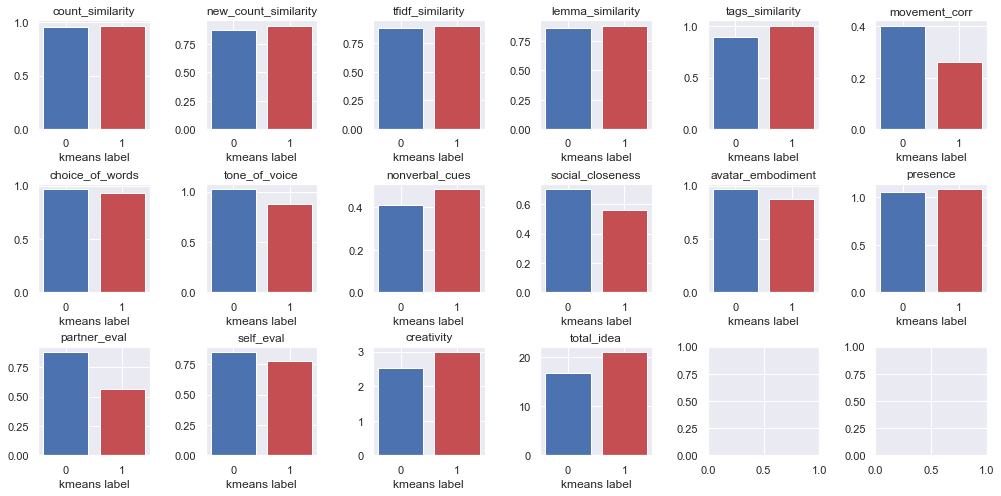

In [65]:
variables = ['count_similarity','new_count_similarity', 'tfidf_similarity','lemma_similarity', 'tags_similarity', 
             'movement_corr','choice_of_words', 'tone_of_voice','nonverbal_cues', 'social_closeness',
             'avatar_embodiment', 'presence','partner_eval', 'self_eval','creativity','total_idea']

fig, axs = plt.subplots(nrows=3, ncols=6)
fig.set_size_inches(17, 8)
fig.subplots_adjust(wspace=0.5)
fig.subplots_adjust(hspace=0.5)

for var, ax in zip(variables, axs.flatten()):
    df_temp = df_trans_comb[["kmeans_label", var]]
    
    x = df_temp.groupby(by='kmeans_label').mean().index.to_list()
    y = df_temp.groupby(by='kmeans_label').mean()[var].to_list()
    
    ax.bar(x, y, color=['b','r'])   
    ax.set_title(var, fontsize=12)
    #ax.get_xaxis().set_visible(False)
    ax.set_xlabel('kmeans label')
    #ax.set_ylabel(var, fontsize=12)
    
plt.show()

Results from both kmeans clusterring show that the text per se do seem to show different patterns and can be broadly categorized into two groups. Where participants in the group which generated more ideas and with higher creativity scores tended to more attention to nonverbal cues, while they did not at all move along with their partners. Participants showed a lower extent of social closeness and also seemed to evaluate their partners more harshly. I wonder if the group of participants were taking the task more seriously and treated it more like serious work than a casual conversation. This does reflect on the sample texts I pulled from both clusters. As transcriptions in cluster 1 tended to be longer and engaged with richer content. However, it doesn't seem like there are much commonality in those actual ideas being generated in the same group. 

Following, spectral clustering also showed similar results and trends:

In [66]:
from sklearn.metrics.pairwise import cosine_distances, cosine_similarity

# Spectral clustering object
spectral_clusterer = SpectralClustering(
    n_clusters=2,
    affinity='precomputed'
)

# Cosine affinitiy matrix
cosine_affinity = cosine_similarity(X_tfidf)

# Perform clustering on similarity matrix
y_spectral = spectral_clusterer.fit_predict(cosine_affinity)

# Print label shape
print("Spectral label vector shape:", y_spectral.shape)

Spectral label vector shape: (75,)


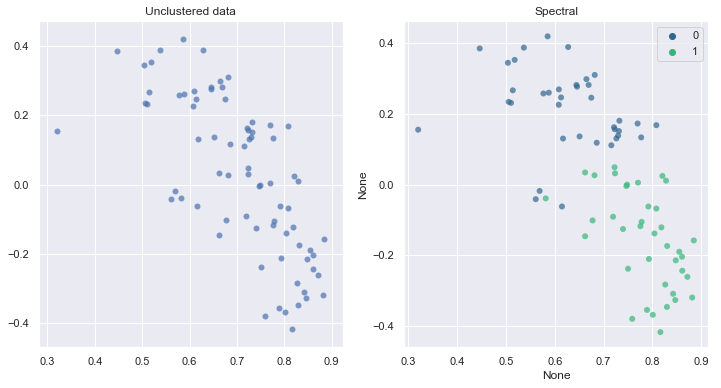

In [67]:
# Plot spectral results
plot_compare(X_tfidf, y_spectral, 'Spectral', alpha=0.7)

In [68]:
pull_samples(df_trans_comb['text_comb'], y_spectral, 3)

Label: 0
Number of texts in this cluster: 37 

Sample text: 31
 yeah I know like umm first yeah like the water bottles like not- using uhh plastic bottles   yeah reusing just yeah so like bringing a water bottle and refilling it instead of just waiting the plastic bottles. yep also like cleaning your clothes-don’t clean clothes that are already clean like only use ones that you like know are dirty. Umm yeah yeah no, right. Umm just like turning things off when you’re not using them like a TV like don’t fall asleep leaving the TV on or like music playing uhh for energy yeah umm yeah carpooling that makes sense yeah umm or like taking like the bus instead of using a car umm when you like clean the- dishes use like a certain amount of water and stop the drain so you don’t just keep the faucet running the whole time. Umm yeah, yeah that’s good umm like turning a fan off when you leave the room, not just leaving it on the whole day umm umm what else? yeah umm you know, they have most of the

In [69]:
# add spectral label to dataframes
y_spectral_label = y_spectral.tolist()
df_trans_comb['spectral_label'] = y_spectral_label

In [70]:
df_trans_comb.groupby(by='spectral_label').mean()

,count_similarity,new_count_similarity,tfidf_similarity,lemma_similarity,tags_similarity,movement_corr,choice_of_words,tone_of_voice,nonverbal_cues,social_closeness,avatar_embodiment,presence,partner_eval,self_eval,creativity,total_idea,kmeans_label
spectral_label,,,,,,,,,,,,,,,,,
0,0.955687,0.879038,0.880229,0.861933,0.881992,0.409895,1.000000,1.027027,0.459459,0.702703,1.005405,1.101351,0.851351,0.864865,2.507598,17.229730,0.081081
1,0.966233,0.914457,0.906711,0.880338,1.026101,0.240706,0.894737,0.868421,0.447368,0.552632,0.834211,1.046053,0.565789,0.763158,3.052086,20.991228,1.000000


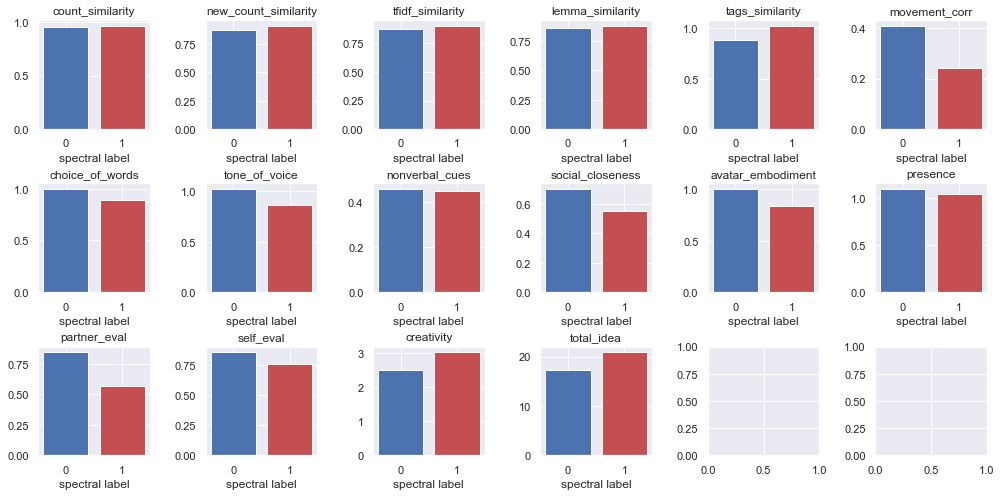

In [71]:
variables = ['count_similarity','new_count_similarity', 'tfidf_similarity','lemma_similarity', 'tags_similarity', 
             'movement_corr','choice_of_words', 'tone_of_voice','nonverbal_cues', 'social_closeness',
             'avatar_embodiment', 'presence','partner_eval', 'self_eval','creativity','total_idea']

fig, axs = plt.subplots(nrows=3, ncols=6)
fig.set_size_inches(17, 8)
fig.subplots_adjust(wspace=0.5)
fig.subplots_adjust(hspace=0.5)


for var, ax in zip(variables, axs.flatten()):
    df_temp = df_trans_comb[["spectral_label", var]]
    
    x = df_temp.groupby(by='spectral_label').mean().index.to_list()
    y = df_temp.groupby(by='spectral_label').mean()[var].to_list()
    
    ax.bar(x, y, color=['b','r'])   
    ax.set_title(var, fontsize=12)
    #ax.get_xaxis().set_visible(False)
    ax.set_xlabel('spectral label')
    #ax.set_ylabel(var, fontsize=12)
    
plt.show()

<br/><br/>
# Classification

With some evidences showing that text data did provide more information than synchrony/nonverbal measures, I move on to examining whether we can effectively classify teams into high vs. low performing groups through text analysis. Again, the major goal here is not to train the perfect classifier, but to examine the potential of relying on text information to predict the level of creativity and the number of ideas being generated. I again look into classifier predicting creativity and count of ideas separately.  

In [72]:
# Get the dimensions of the doc-term matrix
print("Matrix shape:", X_tfidf.shape)

Matrix shape: (75, 308)


In [73]:
# Standard-scale your feature matrix
X_standard = StandardScaler().fit_transform(X_tfidf.todense())

# Print the mean of your scaled features.
# Should be very close to zero.
print("Mean scaled value:", np.mean(X_standard))

Mean scaled value: 4.9215081264768844e-18


<br/><br/>
**3.1 predicting creativity**

In [74]:
# create binary golden label
scores_mean = df_trans_comb.creativity.mean()

y_creativity = []
for c in df_trans_comb['creativity'].tolist():
    if c > scores_mean:
        y_creativity.append(1)
    else:
        y_creativity.append(0)

In [75]:
# Cross-validate the logistic regression classifier on full input data
# Consult PS 6 for leads
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB


# Classifers to test
classifiers = {
    'kNN': KNeighborsClassifier(),
    'Logit':LogisticRegression(),
    'Decision tree':DecisionTreeClassifier(),
    'Random forest':RandomForestClassifier()
}

scores = {} # Store cross-validation results in a dictionary
for classifier in classifiers: 
    scores[classifier] = cross_validate( # perform cross-validation
        classifiers[classifier], # classifier object
        X_standard, # feature matrix
        y_creativity, # gold labels
        cv=10, #number of folds
        scoring=['accuracy', 'f1', 'f1_macro', 'f1_micro'] # scoring methods
    )

In [76]:
# Examine the performance of our classifier
def compare_scores(scores_dict, color=True):
    '''
    Takes a dictionary of cross_validate scores.
    Returns a color-coded Pandas dataframe that summarizes those scores.
    '''
    import pandas as pd
    df = pd.DataFrame(scores_dict).T.applymap(np.mean)
    if color:
        df = df.style.background_gradient(cmap='RdYlGn')
    return df

In [77]:
# Compare cross-validation scores
compare_scores(scores, color=False).style.background_gradient(cmap='RdYlGn')

,fit_time,score_time,test_accuracy,test_f1,test_f1_macro,test_f1_micro
kNN,0.000905,0.003029,0.598214,0.196667,0.461014,0.598214
Logit,0.005003,0.001822,0.614286,0.502381,0.582352,0.614286
Decision tree,0.002482,0.001623,0.541071,0.457540,0.515804,0.541071
Random forest,0.098406,0.007652,0.625000,0.420000,0.567929,0.625000


In [78]:
# Select the 25 most-informative features as specified above 
#  and produce a new feature matrix containing only those features
from sklearn.feature_selection import SelectKBest, mutual_info_classif
selector = SelectKBest(mutual_info_classif, k=25)
X_selected = selector.fit_transform(X_standard, y_creativity)

# Print the shape of your new feature matrix
print("Shape of the new feature matrix:", X_selected.shape)

Shape of the new feature matrix: (75, 25)


In [79]:
# Get the names of the features retained in the new feature matrix
# Store these feature names in a list, then print the list

feature_names = [x for i, x in enumerate(tfidf_vectorizer.get_feature_names()) if selector.get_support()[i]]
display(feature_names)

['brush',
 'brushing',
 'carpooling',
 'dorm',
 'drink',
 'drinking',
 'flushing',
 'going',
 'home',
 'll',
 'makes',
 'people',
 'rains',
 'resources',
 'right',
 'save',
 'saving',
 'showers',
 'times',
 'transportation',
 'turning',
 've',
 'want',
 'way',
 'windows']

In [80]:
# Calculate and display the 10-fold cross-validated accuracy again for the selected features
scores = {} # Store cross-validation results in a dictionary
for classifier in classifiers: 
    scores[classifier] = cross_validate( # perform cross-validation
        classifiers[classifier], # classifier object
        X_selected, # feature matrix
        y_creativity, # gold labels
        cv=10, #number of folds
        scoring=['accuracy', 'f1', 'f1_macro', 'f1_micro'] # scoring methods
    )
compare_scores(scores, color=False).style.background_gradient(cmap='RdYlGn')

,fit_time,score_time,test_accuracy,test_f1,test_f1_macro,test_f1_micro
kNN,0.000580,0.002931,0.658929,0.447619,0.593209,0.658929
Logit,0.004269,0.002115,0.685714,0.635238,0.674856,0.685714
Decision tree,0.001054,0.004636,0.614286,0.579921,0.600833,0.614286
Random forest,0.094199,0.007786,0.750000,0.683333,0.729394,0.750000


In [81]:
# Split the selected feature matrix into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_selected, y_creativity)
model = LogisticRegression().fit(X_train, y_train)

print("Test score:", model.score(X_val, y_val))

Test score: 0.7894736842105263


In [82]:
# Calculate feature importance via permutation
from sklearn.inspection import permutation_importance
r = permutation_importance(model, X_val, y_val, n_repeats=500)

In [83]:
def print_importances(importance_object, feature_names):
    '''
    Takes a trained permutation_importance object and a list of feature names.
    Prints an ordered list of features by descending importance.
    '''
    for i in importance_object.importances_mean.argsort()[::-1]:

        print(f"{feature_names[i]:<8}"
            f"\t{importance_object.importances_mean[i]:.3f}"
            f" +/- {importance_object.importances_std[i]:.3f}")

In [84]:
# Print ranked list of features by permutation importance
print_importances(r, feature_names)

ll      	0.041 +/- 0.023
saving  	0.035 +/- 0.054
going   	0.028 +/- 0.040
showers 	0.019 +/- 0.027
people  	0.017 +/- 0.027
times   	0.015 +/- 0.026
flushing	0.014 +/- 0.044
ve      	0.009 +/- 0.020
rains   	0.007 +/- 0.024
right   	0.000 +/- 0.000
carpooling	0.000 +/- 0.000
brushing	0.000 +/- 0.000
drink   	0.000 +/- 0.000
drinking	0.000 +/- 0.000
transportation	-0.003 +/- 0.026
want    	-0.005 +/- 0.016
save    	-0.006 +/- 0.016
way     	-0.007 +/- 0.017
windows 	-0.011 +/- 0.022
turning 	-0.014 +/- 0.023
resources	-0.015 +/- 0.048
home    	-0.015 +/- 0.024
dorm    	-0.017 +/- 0.045
makes   	-0.020 +/- 0.034
brush   	-0.028 +/- 0.037


<br/><br/>
**3.2. predicting the number of ideas generated**

In [85]:
# create binary golden label
scores_mean = df_trans_comb.total_idea.mean()

y_idea = []
for i in df_trans_comb['total_idea'].tolist():
    if i > scores_mean:
        y_idea.append(1)
    else:
        y_idea.append(0)

In [86]:
# Cross-validate the logistic regression classifier on full input data
# Consult PS 6 for leads
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB


# Classifers to test
classifiers = {
    'kNN': KNeighborsClassifier(),
    'Logit':LogisticRegression(),
    'Decision tree':DecisionTreeClassifier(),
    'Random forest':RandomForestClassifier()
}

scores = {} # Store cross-validation results in a dictionary
for classifier in classifiers: 
    scores[classifier] = cross_validate( # perform cross-validation
        classifiers[classifier], # classifier object
        X_standard, # feature matrix
        y_idea, # gold labels
        cv=10, #number of folds
        scoring=['accuracy', 'f1', 'f1_macro', 'f1_micro'] # scoring methods
    )

In [87]:
# Compare cross-validation scores
compare_scores(scores, color=False).style.background_gradient(cmap='RdYlGn')

,fit_time,score_time,test_accuracy,test_f1,test_f1_macro,test_f1_micro
kNN,0.001051,0.006266,0.614286,0.382857,0.545253,0.614286
Logit,0.014325,0.002975,0.707143,0.709048,0.690714,0.707143
Decision tree,0.002772,0.002821,0.378571,0.421537,0.355768,0.378571
Random forest,0.109598,0.008676,0.655357,0.609365,0.628665,0.655357


In [88]:
# Select the 25 most-informative features as specified above 
#  and produce a new feature matrix containing only those features
from sklearn.feature_selection import SelectKBest, mutual_info_classif
selector = SelectKBest(mutual_info_classif, k=25)
X_selected = selector.fit_transform(X_standard, y_idea)

# Print the shape of your new feature matrix
print("Shape of the new feature matrix:", X_selected.shape)

Shape of the new feature matrix: (75, 25)


In [89]:
# Get the names of the features retained in the new feature matrix
# Store these feature names in a list, then print the list

feature_names = [x for i, x in enumerate(tfidf_vectorizer.get_feature_names()) if selector.get_support()[i]]
display(feature_names)

['15',
 'ac',
 'bike',
 'buildings',
 'buy',
 'collect',
 'dishwasher',
 'dry',
 'efficient',
 'energy',
 'example',
 'gets',
 'good',
 'panels',
 'plant',
 'plants',
 'recycle',
 'set',
 'small',
 'summer',
 'temperature',
 'unplug',
 'unplugging',
 'walk',
 'watering']

In [90]:
# Calculate and display the 10-fold cross-validated accuracy again for the selected features
scores = {} # Store cross-validation results in a dictionary
for classifier in classifiers: 
    scores[classifier] = cross_validate( # perform cross-validation
        classifiers[classifier], # classifier object
        X_selected, # feature matrix
        y_idea, # gold labels
        cv=10, #number of folds
        scoring=['accuracy', 'f1', 'f1_macro', 'f1_micro'] # scoring methods
    )
compare_scores(scores, color=False).style.background_gradient(cmap='RdYlGn')

,fit_time,score_time,test_accuracy,test_f1,test_f1_macro,test_f1_micro
kNN,0.000520,0.002778,0.748214,0.683175,0.723308,0.748214
Logit,0.003605,0.002092,0.762500,0.749206,0.752698,0.762500
Decision tree,0.000563,0.001921,0.682143,0.667857,0.677103,0.682143
Random forest,0.093463,0.007635,0.800000,0.779127,0.791865,0.800000


In [91]:
# Split the selected feature matrix into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_selected, y_idea)
model = RandomForestClassifier().fit(X_train, y_train)

print("Test score:", model.score(X_val, y_val))

Test score: 0.8421052631578947


In [92]:
# Calculate feature importance via permutation
from sklearn.inspection import permutation_importance
r = permutation_importance(model, X_val, y_val, n_repeats=500)

In [93]:
# Print ranked list of features by permutation importance
print_importances(r, feature_names)

energy  	0.087 +/- 0.073
bike    	0.075 +/- 0.042
panels  	0.069 +/- 0.038
buy     	0.058 +/- 0.066
ac      	0.050 +/- 0.041
collect 	0.050 +/- 0.033
efficient	0.046 +/- 0.036
example 	0.044 +/- 0.055
plants  	0.040 +/- 0.035
good    	0.032 +/- 0.030
recycle 	0.026 +/- 0.032
plant   	0.016 +/- 0.033
set     	0.016 +/- 0.038
dishwasher	0.012 +/- 0.023
unplugging	0.009 +/- 0.020
dry     	0.008 +/- 0.020
temperature	0.005 +/- 0.023
summer  	0.005 +/- 0.027
unplug  	0.005 +/- 0.027
small   	0.004 +/- 0.022
buildings	0.004 +/- 0.029
15      	0.003 +/- 0.013
watering	0.002 +/- 0.010
gets    	-0.001 +/- 0.024
walk    	-0.017 +/- 0.044


Overall, we can see some common trends emerging through the series of training and testing classifiers, and these findings apply to both classifying high vs. low creativity as well as high vs. low number of ideas generated. To begin with, outcomes of the classifiers again validate what I saw previously when evaluating results of linear regression and clustering -- that is, text data does have the potential to provide more effective information for prediction than nonverbal/synchrony measures do. Without further adjustment, these classifiers can already effectively predict creativity and idea counts at 70 - 80% of chances. Additionally, I noticed that feature selection plays a key role in improving the performance of these classifiers, suggesting that there are only a small number of key words that highlight participants' performance in the brainstorming task (even though when we look at the list of selected features, they don't seem to provide much insightful cues related to the topic of water and energy conservation).

Furthermore, I noticed that cross-validation test accuracy to predict the number of ideas being generated is much higher than the accuracy to predict the level of creativity. This suggests that two possible explanations. The first, though text data may offer more contextual information, they do not work better in solving contextual than quantitative questions. Besides, just like it is more challenging for RAs to rate creativity scores than to count the number of ideas, it is also more difficult to train a model to read between the lines and get the meaning behind a idea (rather than simply reading and processing words) before it can tell whether an idea is creative or not. 

# Responsibility and resources consulted

I am working solo on this mini project and am responsible for all work produced in the project.

While working on the project, I frequently referred back to code from previous problem sets. I also referred to documentations on the Seaborn website (https://seaborn.pydata.org/index.html), the Pandas website (https://pandas.pydata.org/), and the Matplotlib website (https://matplotlib.org/) to produce visualizations and to manage data tables for the present project.